<h2>Data Import</h2>

In [1]:
import pandas as pd

In [2]:
# Import daily energy consumption totals for all customers with 
# smart meter readings for 2013 (the 'entire' customers)
# into a Pandas dataframe. 

dfTotal = pd.read_csv("./data/DailyTotals.zip")

# Import Acorn designations for all customers.

dfAcorn = pd.read_csv("./data/entireCustomers.zip")

# Import daily energy consumption totals for all customers with complete 
# (non NaN) smart meter readings for 2013 (the 'perfect' customers)
# into a Pandas dataframe. 

dfTotalPerfect = pd.read_csv("./data/perfectDailyTotals.zip")

# Import Acorn designations for the perfect customers.

dfAcornPerfect = pd.read_csv("./data/perfectCustomers.zip")

<h2>Initial Inspection of Data</h2>
<p>A glimpse at the daily energy consumption totals for the first five
customers demonstrates that, contrary to intuition, a higher affluency ranking
does not necessarily indicate higher energy consumption.</p>

In [3]:
# Let's have a look at the dataframe containing daily energy consumption totals.
# In this instance we look at daily energy consumption totals for
# the first 5 customers for the first four days of 2013.

dfTotal.iloc[:,0:5].head()

,id,2013-01-01,2013-01-02,2013-01-03,2013-01-04
0,2,10.800,13.300,10.074,9.857
1,3,18.734,19.980,23.522,20.949
2,4,1.753,1.916,1.722,1.747
3,6,0.500,0.496,0.494,0.495
4,7,13.171,8.031,9.721,9.821


In [4]:
dfAcorn.head()

,id,acorn,acorn-grouped
0,2,ACORN-A,Affluent
1,3,ACORN-P,Adversity
2,4,ACORN-E,Affluent
3,6,ACORN-Q,Adversity
4,7,ACORN-H,Comfortable


In [5]:
# What are the ratios of 'Affluent' and 'Non-Affluent' customers to
# total number of customers ?

dfac = dfAcorn['acorn-grouped'].groupby(dfAcorn['acorn-grouped']).count()
nvals = sum(dfac)
print("Ratio of Affluent customers     = ", sum(dfac.loc[dfac.index=='Affluent']) / nvals)
print("Ratio of non-Affluent customers = ", sum(dfac.loc[dfac.index!='Affluent']) / nvals)

Ratio of Affluent customers     =  0.38245295851280886
Ratio of non-Affluent customers =  0.6175470414871911


<h2>Data Preparation</h2>

In [6]:
target_names = ["Non-Affluent", "Affluent"]

In [7]:
# Create X_entire, y_entire.
# X_entire is a dataframe with total daily energy consumption for all customers.
# y_entire is a list of (observed) Acorn classifications for all customers.

# The following maps the Acorn-group classification to:
#  0 - if the Acorn group is not 'Affluent'
#  1 - if the Acorn group is 'Affluent'

X_entire = dfTotal.drop(columns = ['id'])
y_entire = (dfAcorn['acorn-grouped'] == 'Affluent').astype(int).values

In [8]:
# Sart to build a training set. The project looks at the influence of 
# different training set non-Affluent count to Affluent count ratios have
# on the ability to predict if a customer is Affluent.

# The 'perfect' customers will be used for training. The first step is
# to divide the 'perfect' customers into Affluent and non-Affluent groups,
# each represented by its own DataFrame.

dfAff = dfAcornPerfect.loc[dfAcornPerfect['acorn-grouped']=='Affluent']
dfNonAff = dfAcornPerfect.loc[dfAcornPerfect['acorn-grouped']!='Affluent']

In [9]:
# The following function will allow us to create datasets from dfAff and dfNonAff
# with a specific ratio of non-Affluent to Affluent customers.

from sklearn.model_selection import train_test_split

def affluency_ratio_select(rat):
    
    # Returns test/train datasets taken from the 'perfect' customers
    # with a presribed ratio, rat of Non-affluent to Affluent
    # customer counts.
    
    # First, Take a random sample of rows from the 'non-Affluent' dataframe, 
    # with the number of said rows consistent the presribed ratio, rat.

    dfNonAffSample = dfNonAff.sample(n = int(rat * len(dfAff)), random_state=29)

    # Recombine to form a single dataframe.

    dfSample = dfAff.append(dfNonAffSample)
    dfSample = dfSample.sort_values(by=['id']) 

    # From the total daily energy consumption dataset, select those customers referenced
    # in the dfSample dataframe. This is achieved using a left join using the 'id' of 
    # customers in the 'equal' dataset.

    dfSelect = pd.merge(dfSample['id'], dfTotal, how='left', on = 'id') 

    X = dfSelect.drop(columns = ['id'])
    y = (dfSample['acorn-grouped'] == 'Affluent').astype(int).values

    # Perform a train-test split.
    # Default split ratio is test = 0.25, train = 0.75.
    # The stratify=y ensures that we have pro-rata sampling from each acorn-group.

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29, stratify=y)
    return X_train, X_test, y_train, y_test

<h2>Linear SVM vs. Radial Basis Function SVM</h2>
<p>The sklearn linear SVM is tested against the sklearn radial basis function SVM
for a variety of ratios for non-Affluent customer count to Affluent customer count.</p>

In [10]:
from run_grid import run_grid

# Create a dataframe to house the results of the grid search for each Non-affluent to affluent ratio.
# For each ratio, the results for the best parameter combination are returned (by run_grid) and added 
# as a fresh row to the afore-mentioned dataframe.

dfrbf = pd.DataFrame(columns = ['rat', 'test_acc', 'test_rec', 'test_prc', 'test_f1', \
                                'entire_acc', 'entire_rec', 'entire_prc', 'entire_f1', 'C', 'gamma'])
for i in range(7,16):
    rat = 0.1 * i

    X_train, X_test, y_train, y_test = affluency_ratio_select(rat)
    res = run_grid('rbf', X_train, y_train, X_test, y_test, X_entire, y_entire)
    res['rat'] = rat
    
    print(res)
    # Add a new row of results to the dataframe dfrbf.
    
    dfrbf = dfrbf.append(res, ignore_index=True)  

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.7s finished


{'test_acc': 0.6308724832214765, 'test_rec': 0.8409090909090909, 'test_prc': 0.6434782608695652, 'test_f1': 0.729064039408867, 'entire_acc': 0.5202901836318296, 'entire_rec': 0.8838174273858921, 'entire_prc': 0.4371152154793316, 'entire_f1': 0.5849352687328364, 'C': 1, 'gamma': 0.00031622776601683794, 'rat': 0.7000000000000001}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   15.2s finished
C:\Users\jgree\Anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'test_acc': 0.6178343949044586, 'test_rec': 0.8160919540229885, 'test_prc': 0.6173913043478261, 'test_f1': 0.7029702970297029, 'entire_acc': 0.5617773747449558, 'entire_rec': 0.8257261410788381, 'entire_prc': 0.4594327176781003, 'entire_f1': 0.5903793176520449, 'C': 2, 'gamma': 0.001, 'rat': 0.8}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.1s finished
C:\Users\jgree\Anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'test_acc': 0.6566265060240963, 'test_rec': 0.7471264367816092, 'test_prc': 0.65, 'test_f1': 0.6951871657754011, 'entire_acc': 0.6182271593742915, 'entire_rec': 0.7231772377000593, 'entire_prc': 0.5006155108740254, 'entire_f1': 0.5916585838991271, 'C': 1, 'gamma': 0.0005623413251903491, 'rat': 0.9}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   22.8s finished


{'test_acc': 0.6628571428571428, 'test_rec': 0.6363636363636364, 'test_prc': 0.6746987951807228, 'test_f1': 0.6549707602339182, 'entire_acc': 0.6479256404443436, 'entire_rec': 0.5666864256075874, 'entire_prc': 0.5376827896512936, 'entire_f1': 0.5518037518037517, 'C': 1, 'gamma': 0.00031622776601683794, 'rat': 1.0}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   23.6s finished


{'test_acc': 0.6284153005464481, 'test_rec': 0.5172413793103449, 'test_prc': 0.6338028169014085, 'test_f1': 0.5696202531645571, 'entire_acc': 0.6626615279981863, 'entire_rec': 0.5180794309425015, 'entire_prc': 0.5642349903163331, 'entire_f1': 0.5401730531520396, 'C': 2, 'gamma': 0.00017782794100389227, 'rat': 1.1}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.6s finished
C:\Users\jgree\Anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'test_acc': 0.6302083333333334, 'test_rec': 0.5517241379310345, 'test_prc': 0.6, 'test_f1': 0.5748502994011977, 'entire_acc': 0.6440716390841079, 'entire_rec': 0.6330764671013633, 'entire_prc': 0.5289747399702823, 'entire_f1': 0.5763626551538047, 'C': 5, 'gamma': 0.00031622776601683794, 'rat': 1.2000000000000002}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   27.1s finished


{'test_acc': 0.6119402985074627, 'test_rec': 0.42528735632183906, 'test_prc': 0.5692307692307692, 'test_f1': 0.4868421052631578, 'entire_acc': 0.6762638857401949, 'entire_rec': 0.5340841730883225, 'entire_prc': 0.5839274141283215, 'entire_f1': 0.5578947368421053, 'C': 3, 'gamma': 0.00017782794100389227, 'rat': 1.3}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   29.5s finished


{'test_acc': 0.6238095238095238, 'test_rec': 0.23863636363636365, 'test_prc': 0.6363636363636364, 'test_f1': 0.34710743801652894, 'entire_acc': 0.67377012015416, 'entire_rec': 0.3005334914048607, 'entire_prc': 0.6618798955613577, 'entire_f1': 0.41337138198124745, 'C': 1, 'gamma': 0.0001, 'rat': 1.4000000000000001}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.7s finished


{'test_acc': 0.6238532110091743, 'test_rec': 0.2413793103448276, 'test_prc': 0.5675675675675675, 'test_f1': 0.33870967741935487, 'entire_acc': 0.6828383586488325, 'entire_rec': 0.34676941315945464, 'entire_prc': 0.6632653061224489, 'entire_f1': 0.45543012845465164, 'C': 2, 'gamma': 0.0001, 'rat': 1.5}


<p>Here is the dataframe that contains results from the optimal parameter combination for
each training ratio. The peak f1 score when measured after applying the model to the entire 
set of customers is 0.591, which is attained at a training ratio of 0.9.</p>

In [11]:
dfrbf

,rat,test_acc,test_rec,test_prc,test_f1,entire_acc,entire_rec,entire_prc,entire_f1,C,gamma
0,0.7,0.630872,0.840909,0.643478,0.729064,0.520290,0.883817,0.437115,0.584935,1.0,0.000316
1,0.8,0.617834,0.816092,0.617391,0.702970,0.561777,0.825726,0.459433,0.590379,2.0,0.001000
2,0.9,0.656627,0.747126,0.650000,0.695187,0.618227,0.723177,0.500616,0.591659,1.0,0.000562
3,1.0,0.662857,0.636364,0.674699,0.654971,0.647926,0.566686,0.537683,0.551804,1.0,0.000316
4,1.1,0.628415,0.517241,0.633803,0.569620,0.662662,0.518079,0.564235,0.540173,2.0,0.000178
5,1.2,0.630208,0.551724,0.600000,0.574850,0.644072,0.633076,0.528975,0.576363,5.0,0.000316
6,1.3,0.611940,0.425287,0.569231,0.486842,0.676264,0.534084,0.583927,0.557895,3.0,0.000178
7,1.4,0.623810,0.238636,0.636364,0.347107,0.673770,0.300533,0.661880,0.413371,1.0,0.000100
8,1.5,0.623853,0.241379,0.567568,0.338710,0.682838,0.346769,0.663265,0.455430,2.0,0.000100


In [12]:
dflin = pd.DataFrame(columns = ['rat', 'test_acc', 'test_rec', 'test_prc', 'test_f1', \
                                'entire_acc', 'entire_rec', 'entire_prc', 'entire_f1', 'C'])

for i in range(7,16):
    rat = 0.1 * i

    X_train, X_test, y_train, y_test = affluency_ratio_select(rat)
    res = run_grid('linear', X_train, y_train, X_test, y_test, X_entire, y_entire)
    res['rat'] = rat
    
    print(res)
    dflin = dflin.append(res, ignore_index=True)  

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished


{'test_acc': 0.5234899328859061, 'test_rec': 0.5909090909090909, 'test_prc': 0.5977011494252874, 'test_f1': 0.5942857142857143, 'entire_acc': 0.5395601904330084, 'entire_rec': 0.6141078838174274, 'entire_prc': 0.4288079470198676, 'entire_f1': 0.5049963441384353, 'C': 1, 'rat': 0.7000000000000001}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.3s finished


{'test_acc': 0.5095541401273885, 'test_rec': 0.5977011494252874, 'test_prc': 0.5531914893617021, 'test_f1': 0.5745856353591161, 'entire_acc': 0.555656313761052, 'entire_rec': 0.6253704801422644, 'entire_prc': 0.44271926143516577, 'entire_f1': 0.5184275184275184, 'C': 1, 'rat': 0.8}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.6s finished


{'test_acc': 0.5240963855421686, 'test_rec': 0.4942528735632184, 'test_prc': 0.5512820512820513, 'test_f1': 0.5212121212121212, 'entire_acc': 0.5930627975515756, 'entire_rec': 0.5743924125666864, 'entire_prc': 0.4736070381231672, 'entire_f1': 0.5191534958478435, 'C': 1, 'rat': 0.9}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


{'test_acc': 0.5257142857142857, 'test_rec': 0.5568181818181818, 'test_prc': 0.5268817204301075, 'test_f1': 0.5414364640883979, 'entire_acc': 0.5785536159600998, 'entire_rec': 0.5951393005334914, 'entire_prc': 0.46055045871559636, 'entire_f1': 0.5192655805534007, 'C': 1, 'rat': 1.0}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.2s finished


{'test_acc': 0.546448087431694, 'test_rec': 0.5287356321839081, 'test_prc': 0.5227272727272727, 'test_f1': 0.5257142857142857, 'entire_acc': 0.592609385626842, 'entire_rec': 0.5826911677534085, 'entire_prc': 0.4735067437379576, 'entire_f1': 0.5224554876428382, 'C': 1, 'rat': 1.1}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


{'test_acc': 0.5052083333333334, 'test_rec': 0.4482758620689655, 'test_prc': 0.45348837209302323, 'test_f1': 0.45086705202312144, 'entire_acc': 0.591475855815008, 'entire_rec': 0.5779490219324244, 'entire_prc': 0.4721549636803874, 'entire_f1': 0.5197228144989339, 'C': 1, 'rat': 1.2000000000000002}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


{'test_acc': 0.5024875621890548, 'test_rec': 0.41379310344827586, 'test_prc': 0.4235294117647059, 'test_f1': 0.4186046511627907, 'entire_acc': 0.597370210836545, 'entire_rec': 0.5394190871369294, 'entire_prc': 0.47668936616029334, 'entire_f1': 0.5061179087875417, 'C': 1, 'rat': 1.3}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


{'test_acc': 0.5095238095238095, 'test_rec': 0.3522727272727273, 'test_prc': 0.4025974025974026, 'test_f1': 0.3757575757575758, 'entire_acc': 0.6157333937882566, 'entire_rec': 0.5423829282750444, 'entire_prc': 0.49782372143634385, 'entire_f1': 0.5191489361702127, 'C': 1, 'rat': 1.4000000000000001}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished


{'test_acc': 0.536697247706422, 'test_rec': 0.42528735632183906, 'test_prc': 0.42045454545454547, 'test_f1': 0.4228571428571428, 'entire_acc': 0.6050782135570165, 'entire_rec': 0.5305275637225845, 'entire_prc': 0.48509485094850946, 'entire_f1': 0.5067950169875425, 'C': 1, 'rat': 1.5}


<p>Here is the dataframe that contains results from the optimal parameter combination for each training ratio for the
case in which a linear SVM model has been trained,</p>
<p>The peak F1 score for an evaluation of the linear SVM model's performance on the entire dataset is 0.522 and 
is attained for a training ratio of 1.1. This value is notably lower than the peak F1 score attained
for the radial basis function SVM, which attained a value of .591 at a training ratio of 0.9.</p>

In [13]:
dflin

,rat,test_acc,test_rec,test_prc,test_f1,entire_acc,entire_rec,entire_prc,entire_f1,C
0,0.7,0.523490,0.590909,0.597701,0.594286,0.539560,0.614108,0.428808,0.504996,1.0
1,0.8,0.509554,0.597701,0.553191,0.574586,0.555656,0.625370,0.442719,0.518428,1.0
2,0.9,0.524096,0.494253,0.551282,0.521212,0.593063,0.574392,0.473607,0.519153,1.0
3,1.0,0.525714,0.556818,0.526882,0.541436,0.578554,0.595139,0.460550,0.519266,1.0
4,1.1,0.546448,0.528736,0.522727,0.525714,0.592609,0.582691,0.473507,0.522455,1.0
5,1.2,0.505208,0.448276,0.453488,0.450867,0.591476,0.577949,0.472155,0.519723,1.0
6,1.3,0.502488,0.413793,0.423529,0.418605,0.597370,0.539419,0.476689,0.506118,1.0
7,1.4,0.509524,0.352273,0.402597,0.375758,0.615733,0.542383,0.497824,0.519149,1.0
8,1.5,0.536697,0.425287,0.420455,0.422857,0.605078,0.530528,0.485095,0.506795,1.0


<h2>Further Optimization by Parameter</h2>
<p>In this section we manually tweak the parameters (without cross-validation) in order to 
assess whether improvements can be made to prective accuracy when appied to the entire customer
set.</p>

In [14]:
X_train, X_test, y_train, y_test = affluency_ratio_select(0.9)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from sklearn.metrics import classification_report

model = SVC(kernel = 'rbf', max_iter = 1000000, C = 1, gamma = .000562)
model.fit(X_train, y_train)

from report_model_performance import report_model
report_model(model, X_entire, y_entire, target_names)

Number of accurate predictions =  2727
Ratio of accurate predictions =  0.62 

              precision    recall  f1-score   support

Non-Affluent       0.76      0.55      0.64      2724
    Affluent       0.50      0.72      0.59      1687

   micro avg       0.62      0.62      0.62      4411
   macro avg       0.63      0.64      0.62      4411
weighted avg       0.66      0.62      0.62      4411

0.7231772377000593


In [16]:
import numpy as np
a = np.full((5, 12), 0.0)

from report_model_performance import report_model_performance

for i in range(5):
    for j in range(12):
        C = i+1
        gamma = 10 **(-4 + 0.25*j)
        
        model = SVC(kernel = 'rbf', max_iter = 1000000, C=C, gamma = gamma)
        model.fit(X_train, y_train)
    
        acc, rec, prc, f1s = report_model_performance(model, X_entire, y_entire, target_names)
    
        a[i][j] = f1s

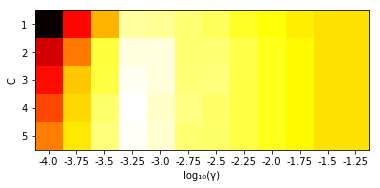

In [17]:
# Create a heat-map plot of the f1-score for various C, gamma parameter combinations
# for the case in which a nonAffluent to Affluent customer count ratio of 0.9 is used.

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(a, cmap='hot', interpolation='nearest')

xtls = [(-4 + 0.25*j) for j in range(12)]
ytls = [j+1 for j in range(5)]
plt.xticks(list(range(12)), xtls)
plt.yticks(list(range(5)), ytls)
plt.xlabel("log\u2081\u2080(\u03B3)")
plt.ylabel("C")
plt.show()

In [18]:
# The heat map shown above suggests that C=4, gamma = 10^(-3.25) [=.000562]
# might have produced a slightly better model for the case where the Non-Aff:Aff
# ratio = 0.9. This turns out to be true, if only marginally (f1-score = 0.6).

model = SVC(kernel = 'rbf', max_iter = 1000000, C = 4, gamma = .000562)
model.fit(X_train, y_train)
report_model(model, X_entire, y_entire, target_names)

Number of accurate predictions =  2683
Ratio of accurate predictions =  0.61 

              precision    recall  f1-score   support

Non-Affluent       0.78      0.51      0.62      2724
    Affluent       0.49      0.76      0.60      1687

   micro avg       0.61      0.61      0.61      4411
   macro avg       0.64      0.64      0.61      4411
weighted avg       0.67      0.61      0.61      4411

0.7646710136336692
